In [1]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
from acousticnn.mmo import get_dataloader, Iter_Dataset
from acousticnn.mmo import train
from acousticnn.utils.builder import build_opti_sche, build_model
from acousticnn.utils.logger import init_train_logger, print_log
from acousticnn.utils.argparser import get_args, get_config
from torchinfo import summary
import wandb 
import time
import os
import torch
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['axes.labelsize'] = 9
rcParams['axes.titlesize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams["figure.figsize"] = (10 / 2.54, 8 / 2.54)

In [3]:
def plot_loss(losses_per_f, f, ax=None, quantile=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    losses_per_f = losses_per_f.transpose(0, 2, 1).reshape(-1, 200)
    mean = np.mean(losses_per_f, axis=0)
    std = np.std(losses_per_f, axis=0)
    ax.semilogx(f, mean)
    if quantile is not None:
        quantiles = np.quantile(losses_per_f, [0+quantile, 1-quantile], axis=0)
        ax.fill_between(f, quantiles[0], quantiles[1], alpha=0.2)

    ax.set_xlabel('Angular frequency in rad/s')
    ax.set_ylabel('rmse dB re 1m')
    return ax

def plot_results(prediction, amplitude, f, ax=None, quantile=None, linestyle = '--'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 12))

    ax.semilogx(f, prediction, c='black', alpha = 0.8)
    ax.semilogx(f, amplitude, c='red', linestyle = linestyle)

    ax.grid(True)
    ax.set_xlabel('Angular frequency in rad/s')
    ax.set_ylabel('Amplitude in dB re 1m')
    return ax

In [4]:
args = get_args(["--config", "configs/explicit_mlp.yaml"])
args.encoding = "none"
config = get_config("configs/implicit_transformer.yaml")

def get_dataloader_helper(n_masses, n_samples, test, batch_size):
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    parameters_dataset = {"n_masses": n_masses, 
            "sample_f": False,
            "f_per_sample": 200,
            "sample_m": True,
            "m_range": (1, 25),
            "sample_d": True,
            "d_range": (0.1, 1),
            "sample_k": True,
            "k_range": (1, 30),
            "normalize": False,
            "normalize_factor": 10,
            "f_range": (-1.5, 1)
    }    
    if args.encoding == "none":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 10
        config.model.input_encoding = "none"
    elif args.encoding == "random":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 10
        config.model.input_encoding = "random"
    elif args.encoding == "sin":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 100
        config.model.input_encoding = "sin"
    else:
        raise NotImplementedError
    return get_dataloader(args, config, test=test, n_samples=n_samples, parameters=parameters_dataset, batch_size=batch_size)
valloader = get_dataloader_helper(4, 1000, True, 100)
f = np.logspace(-1.5, 1, 200)

{'n_masses': 4, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f
Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(12.9785) tensor(6.9809)
tensor(0.5434) tensor(0.2591)
tensor(15.3790) tensor(8.3880)
tensor(0.1859) tensor(2.4163)
tensor(-0.0086) tensor(2.7924)
tensor(-0.0660) tensor(2.5907)
tensor(-0.0403) tensor(2.7960)


In [5]:
def generate_prediction():
    pred, amp, losses, losses_per_f = [], [], [], []
    with torch.no_grad():
        for frequency, parameters, amplitude in valloader: 
            frequency, parameters, amplitude = frequency.to(args.device), [par.to(args.device) for par in parameters], amplitude.to(args.device)
            prediction = net(frequency, parameters) # B x num_masses x num_frequencies    
            prediction = prediction * 10
            amplitude = amplitude * 10
            loss = torch.nn.functional.mse_loss(prediction, amplitude)
            amplitude, prediction = amplitude.cpu(), prediction.cpu()
            pred.append(prediction), amp.append(amplitude), losses.append(loss.cpu())
            losses_per_f.append(torch.nn.functional.mse_loss(prediction, amplitude, reduction="none").detach().cpu().numpy())

    losses_per_f = np.vstack(losses_per_f)
    rmse_per_f = np.sqrt(losses_per_f)
    prediction, amplitude = np.vstack(pred), np.vstack(amp)
    print(np.mean(losses_per_f)) 
    return prediction, amplitude, rmse_per_f

## Transfer TODO

In [8]:
path = r"C:\Users\Schultz\NextCloud\WorkingDir\Projects\D2A\Code\spp_ai_acoustics\acousticnn\mmo\experiments\mass_variation\checkpoint_best"
# transformer
args.device = "cpu"
config = get_config("configs/implicit_transformer.yaml")
config.model.input_encoding = "none"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path, map_location= "cpu")["model_state_dict"])
prediction_cond2, amplitude_cond2, losses_per_f_cond2 = generate_prediction()


loss_per_sample4 = np.mean(np.mean(losses_per_f_cond2, axis=1), axis=1)
print(np.argmin(loss_per_sample4), np.argmax(loss_per_sample4))
print(loss_per_sample4[np.argmin(loss_per_sample4)], loss_per_sample4[np.argmax(loss_per_sample4)])

0.0008549094
177 668
0.005272591 0.040901616


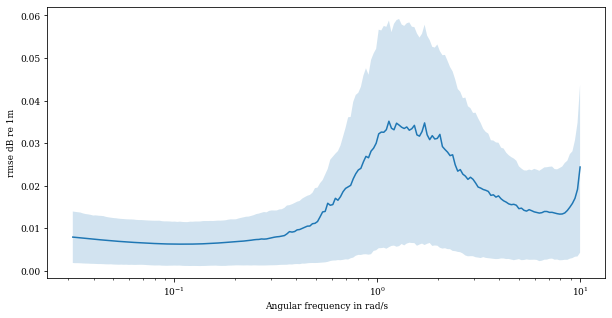

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
plot = plot_loss(losses_per_f_cond2, f, ax, quantile=0.15)

IndexError: index 2 is out of bounds for axis 1 with size 2

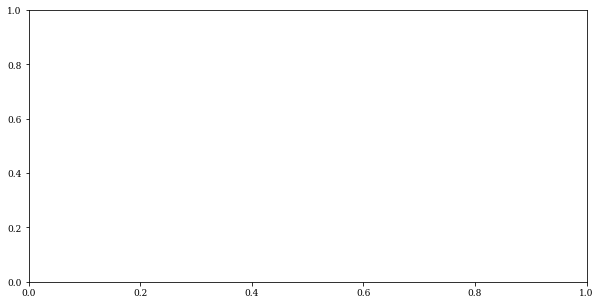

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
i=[0,1,2, 3]
num= 973
#plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax[0])
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)

### evaluate on different numbers of masses

In [11]:
path = r"C:\Users\Schultz\NextCloud\WorkingDir\Projects\D2A\Code\spp_ai_acoustics\acousticnn\mmo\experiments\mass_variation\checkpoint_best"
# transformer
config = get_config("configs/implicit_transformer.yaml")
config.model.input_encoding = "none"
args.device = "cpu"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path, map_location= "cpu")["model_state_dict"])
valloader = get_dataloader_helper(2, 1000, True, 16)
prediction_cond1, amplitude_cond1, losses_per_f_cond1 = generate_prediction()
loss_per_sample1 = np.mean(np.mean(losses_per_f_cond1, axis=1), axis=1)
print(np.argmin(loss_per_sample1), np.argmax(loss_per_sample1))
print(loss_per_sample1[np.argmin(loss_per_sample1)], loss_per_sample1[np.argmax(loss_per_sample1)])

{'n_masses': 2, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f
Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(13.0873) tensor(7.0796)
tensor(0.5433) tensor(0.2566)
tensor(15.3022) tensor(8.4322)
tensor(0.1859) tensor(2.4163)
tensor(0.0349) tensor(2.8318)
tensor(-0.0673) tensor(2.5663)
tensor(-0.0659) tensor(2.8107)
0.0008549094
177 668
0.005272591 0.040901616


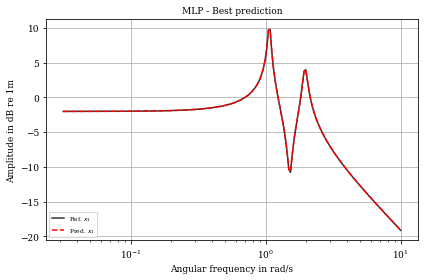

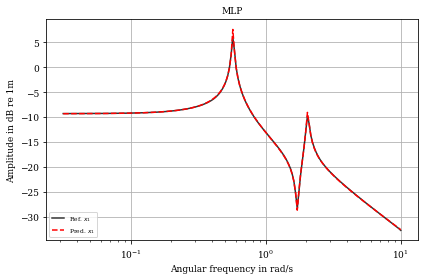

In [12]:
# MLP plots
idx_min_loss_1 = np.argmin(loss_per_sample4)
idx_max_loss_1 = np.argmax(loss_per_sample4)
legend_font_size = 6
fig, ax = plt.subplots(1, 1)
i=[0]
num= idx_min_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)
plot.set_title("MLP - Best prediction")
plot.legend(["Ref. $x_1$","Pred. $x_1$"], prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_MLP_Best.png", format='png', dpi = 600)
fig.savefig("samples_MLP_Best.pdf", format='pdf')

fig, ax = plt.subplots(1, 1)
i=[0]
num= idx_max_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)
plot.set_title("MLP")
plot.legend(["Ref. $x_1$","Pred. $x_1$"], prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_MLP_Worst.png", format='png', dpi = 600)
fig.savefig("samples_MLP_Worst.pdf", format='pdf')

In [13]:
valloader = get_dataloader_helper(3, 1000, True, 16)
prediction_cond2, amplitude_cond2, losses_per_f_cond2 = generate_prediction()
loss_per_sample2 = np.mean(np.mean(losses_per_f_cond2, axis=1), axis=1)
print(np.argmin(loss_per_sample2), np.argmax(loss_per_sample2))
print(loss_per_sample2[np.argmin(loss_per_sample2)], loss_per_sample2[np.argmax(loss_per_sample2)])

{'n_masses': 3, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f
Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(13.1018) tensor(7.0143)
tensor(0.5403) tensor(0.2575)
tensor(15.3528) tensor(8.4110)
tensor(0.1859) tensor(2.4163)
tensor(0.0407) tensor(2.8057)
tensor(-0.0971) tensor(2.5747)
tensor(-0.0491) tensor(2.8037)
0.009000413
0 354
0.011266499 0.2609525


In [14]:
valloader = get_dataloader_helper(5, 1000, True, 16)
prediction_cond3, amplitude_cond3, losses_per_f_cond3 = generate_prediction()
loss_per_sample3 = np.mean(np.mean(losses_per_f_cond3, axis=1), axis=1)
print(np.argmin(loss_per_sample3), np.argmax(loss_per_sample3))
print(loss_per_sample3[np.argmin(loss_per_sample3)], loss_per_sample3[np.argmax(loss_per_sample3)])

{'n_masses': 5, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f


Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(12.9273) tensor(6.9394)
tensor(0.5447) tensor(0.2604)
tensor(15.3032) tensor(8.4254)
tensor(0.1859) tensor(2.4163)
tensor(-0.0291) tensor(2.7758)
tensor(-0.0534) tensor(2.6042)
tensor(-0.0656) tensor(2.8085)
0.040158603
255 575
0.03146612 0.4603897


In [15]:
valloader = get_dataloader_helper(6, 1000, True, 16)
prediction_cond4, amplitude_cond4, losses_per_f_cond4 = generate_prediction()
loss_per_sample4 = np.mean(np.mean(losses_per_f_cond4, axis=1), axis=1)
print(np.argmin(loss_per_sample4), np.argmax(loss_per_sample4))
print(loss_per_sample4[np.argmin(loss_per_sample4)], loss_per_sample4[np.argmax(loss_per_sample4)])

{'n_masses': 6, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f


Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(12.9130) tensor(6.9435)
tensor(0.5458) tensor(0.2604)
tensor(15.3804) tensor(8.4848)
tensor(0.1859) tensor(2.4163)
tensor(-0.0348) tensor(2.7774)
tensor(-0.0416) tensor(2.6039)
tensor(-0.0399) tensor(2.8283)
0.09128899
266 234
0.053041905 0.5687142


In [16]:
plot = plot_loss(losses_per_f_cond1, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond2, f, ax, quantile=0.1)
plot.set_title("Error")
plot.legend(["mean - Grid appr.","90 % quant.", "mean - Querry appr.", " 90 % quant."], ncol = 1, prop = {'size': 9}, loc = 'upper left')
plot.set_ylim([0.0, 5.0])
plt.tight_layout()
fig.savefig("losses_query_fixed.png", format='png', dpi = 600)

<Figure size 432x288 with 0 Axes>

C:\Users\Schultz\AppData\Local\Temp\ipykernel_11884\634719644.py:9: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x0000025320D7BA30> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(legend_labels, ncol = 1, prop = {'size': legend_font_size}, loc = 'upper left')
C:\Users\Schultz\AppData\Local\Temp\ipykernel_11884\634719644.py:9: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x0000025320D8B100> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(legend_labels, ncol = 1, prop = {'size': legend_font_size}, loc = 'upper left')
C:\Users\Schultz\AppData\Local\Temp\ipykernel_11884\634719644.py:9: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x0000025320D8B790> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(legend_labels, ncol = 1, prop = {'size': legend_font_size}, loc = 'upper left')
C:\Users\Schultz\AppData\Local\

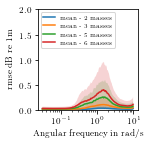

In [24]:
rcParams["text.usetex"] = True

fig, ax = plt.subplots(1, 1, figsize=(5.4 / 2.54, 5.4 / 2.54))
plot = plot_loss(losses_per_f_cond1, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond2, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond3, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond4, f, ax, quantile=0.1)
legend_labels = ["mean - 2 masses", "_", "mean - 3 masses", "_", "mean - 5 masses", "_", "mean - 6 masses", "_"]
ax.legend(legend_labels, ncol = 1, prop = {'size': legend_font_size}, loc = 'upper left')
plot.set_ylim([0.0, 2.0])
#ax.grid(True)
plt.tight_layout()
fig.savefig("losses.png", format='png', dpi = 600)
fig.savefig("multi_masses.pdf", format='pdf')

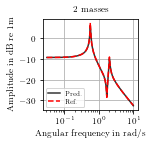

In [18]:
# Transformer plots
idx_min_loss_1 = np.argmin(loss_per_sample1)
idx_max_loss_1 = np.argmax(loss_per_sample1)


legend_font_size = 6
fig, ax = plt.subplots(1, 1, figsize=(5.4 / 2.54, 5.4 / 2.54))
i=[0]
num= idx_max_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)

legend_labels = ["Pred.", "Ref."]

plot.set_title("2 masses")
plot.legend(legend_labels, prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_transformer_n2.png", format='png', dpi = 600)
fig.savefig("samples_transformer_n2.pdf", format='pdf')

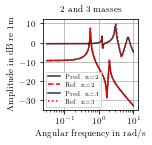

In [19]:
# Transformer plots
idx_min_loss_1 = np.argmin(loss_per_sample1)
idx_max_loss_1 = np.argmax(loss_per_sample1)

idx_min_loss_2 = np.argmin(loss_per_sample2)
idx_max_loss_2 = np.argmax(loss_per_sample2)

legend_font_size = 6
fig, ax = plt.subplots(1, 1, figsize=(5.4 / 2.54, 5.4 / 2.54))
i=[0]
num= idx_max_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax, linestyle= "dashed")

num= idx_max_loss_2
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax, linestyle= ":")

legend_labels = ["Pred. n=2", "Ref. n=2", "Pred. n=3", "Ref. n=3"]

plot.set_title("2 and 3 masses")
plot.legend(legend_labels, prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_transformer_n2_3.png", format='png', dpi = 600)
fig.savefig("samples_transformer_n2_3.pdf", format='pdf')

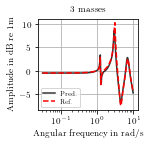

In [20]:
# Transformer plots
idx_min_loss_2 = np.argmin(loss_per_sample2)
idx_max_loss_2 = np.argmax(loss_per_sample2)

legend_font_size = 6
fig, ax = plt.subplots(1, 1, figsize=(5.4 / 2.54, 5.4 / 2.54))
i=[0]
num= idx_max_loss_2
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)

legend_labels = ["Pred.", "Ref."]

plot.set_title("3 masses")
plot.legend(legend_labels, prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_transformer_n3.png", format='png', dpi = 600)
fig.savefig("samples_transformer_n3.pdf", format='pdf')

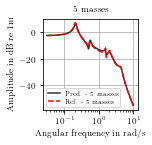

In [21]:
# Transformer plots
idx_min_loss_3 = np.argmin(loss_per_sample3)
idx_max_loss_3 = np.argmax(loss_per_sample3)


legend_font_size = 6
fig, ax = plt.subplots(1, 1, figsize=(5.4 / 2.54, 5.4 / 2.54))
i=[2]
num= idx_max_loss_3
plot = plot_results(prediction_cond3[num][:,i], amplitude_cond3[num][:,i], f, ax)

legend_labels = ["Pred. - 5 masses", "Ref. - 5 masses"]

plot.set_title("5 masses")
plot.legend(legend_labels, prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_transformer_n5.png", format='png', dpi = 600)
fig.savefig("samples_transformer_n5.pdf", format='pdf')

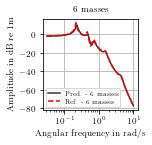

In [22]:
# Transformer plots
idx_min_loss_4 = np.argmin(loss_per_sample4)
idx_max_loss_4 = np.argmax(loss_per_sample4)


legend_font_size = 6
fig, ax = plt.subplots(1, 1, figsize=(5.4 / 2.54, 5.4 / 2.54))
i=[3]
num= idx_max_loss_4
plot = plot_results(prediction_cond4[num][:,i], amplitude_cond4[num][:,i], f, ax)

legend_labels = ["Pred. - 6 masses", "Ref. - 6 masses"]

plot.set_title("6 masses")
plot.legend(legend_labels, prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_transformer_n6.png", format='png', dpi = 600)
fig.savefig("samples_transformer_n6.pdf", format='pdf')

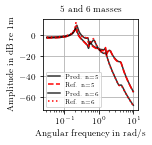

In [23]:
# Transformer plots
idx_min_loss_3 = np.argmin(loss_per_sample3)
idx_max_loss_3 = np.argmax(loss_per_sample3)

idx_min_loss_4 = np.argmin(loss_per_sample4)
idx_max_loss_4 = np.argmax(loss_per_sample4)

legend_font_size = 6
fig, ax = plt.subplots(1, 1, figsize=(5.4 / 2.54, 5.4 / 2.54))
i=[2]
num= idx_max_loss_3
plot = plot_results(prediction_cond3[num][:,i], amplitude_cond3[num][:,i], f, ax, linestyle= 'dashed')

num= idx_max_loss_4
plot = plot_results(prediction_cond4[num][:,i], amplitude_cond4[num][:,i], f, ax, linestyle= ':')

legend_labels = ["Pred. n=5", "Ref. n=5", "Pred. n=6", "Ref. n=6"]

plot.set_title("5 and 6 masses")
plot.legend(legend_labels, prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_transformer_n5_6.png", format='png', dpi = 600)
fig.savefig("samples_transformer_n5_6.pdf", format='pdf')

### finetune on 4 masses ignore

In [ ]:
from acousticnn.mmo import train
from acousticnn.utils.builder import build_opti_sche
args.seed=1234

In [ ]:
trainloader = get_dataloader_helper(4, 100, False, 16)
net.load_state_dict(torch.load(path)["model_state_dict"])
optimizer, scheduler = build_opti_sche(net, config)
config.epochs = 1000
config.scheduler.kwargs.epochs = config.epochs
config.scheduler.kwargs.initial_epochs = 50
train(args, config, net, trainloader, optimizer, valloader, scheduler=scheduler, logger=None) # 16.83

In [ ]:
trainloader = get_dataloader_helper(4, 250, False, 16)
net.load_state_dict(torch.load(path)["model_state_dict"])
optimizer, scheduler = build_opti_sche(net, config)
config.epochs = 1000
config.scheduler.kwargs.epochs = config.epochs
config.scheduler.kwargs.initial_epochs = 50
train(args, config, net, trainloader, optimizer, valloader, scheduler=scheduler, logger=None) # 1.562

In [ ]:
trainloader = get_dataloader_helper(4, 500, False, 16)
net.load_state_dict(torch.load(path)["model_state_dict"])
optimizer, scheduler = build_opti_sche(net, config)
config.epochs = 1000
config.scheduler.kwargs.epochs = config.epochs
config.scheduler.kwargs.initial_epochs = 50
train(args, config, net, trainloader, optimizer, valloader, scheduler=scheduler, logger=None) #  0.6747

In [ ]:
trainloader = get_dataloader_helper(4, 1000, False, 16)
net.load_state_dict(torch.load(path)["model_state_dict"])
optimizer, scheduler = build_opti_sche(net, config)
config.epochs = 1000
config.scheduler.kwargs.epochs = config.epochs
config.scheduler.kwargs.initial_epochs = 50
train(args, config, net, trainloader, optimizer, valloader, scheduler=scheduler, logger=None) # 0.01

In [ ]:
# see experiments/data_variation
n_samples = [100, 250, 500, 1000, 1500, 2000, 4000, 8000]
loss = [35.17, 9.987, 1.754, 0.2799, 0.1318, 0.07344, 0.03755,  0.01823]

n_samples_finetuning = [100, 250, 500, 1000]
loss_finetuning = [22.96, 2.291, 0.6747, 0.2442]

plt.semilogy(n_samples, loss, 'o-', label='Training from scratch')
plt.semilogy(n_samples_finetuning, loss_finetuning, 'o-', label='Finetuning')

# Set labels and title
plt.xlabel('Number of Samples')
plt.ylabel('MSE (log scale)')
plt.title('Comparison of Training from Scratch and Finetuning')

# Add legend
plt.legend()